# What is batch effect?
> Batch effect refers to technical variation or non-biological differences between measurements of different groups of samples.

> Although batch effect can be reduced by good experimental design, it is difficult to completely eradicate.


> Batch effects can lead to inaccurate conclusions when their causes are correlated with one or more outcomes of interest in an experiment.

- https://en.wikipedia.org/wiki/Batch_effect/
- https://www.nature.com/articles/s41598-017-11110-6

#### They are most commonly discussed in the context of genomics and high-throughput sequencing research, but they exist in other fields of science as well.


# So... can we identify and remove Batch Effects?

- There's an excellent visual explanation from 10x Genomics.

### Identify and correct Batch Effects. From 10x Genomics


<img src="https://cdn.10xgenomics.com/image/upload/v1629241143/analysis-guides/BatchCorrection-Intro.png"  width="600" height="300">

- As you can see from the image, there were clearly signs of batch effects from different experiment, and the right image shows the batch effect is diminished through processing. 

# How can one identify batch effect?
- For the simplest, dimension reduction methods like PCA will do. 
- Let's figure out first 10 batches have batch effects or not!

In [1]:
import pandas as pd
import os
import pyarrow.parquet as pq
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


In [2]:
def get_batchdata(batch_num,batch_dir):
    sensor_info_df = pq.read_table(batch_dir+'batch_'+str(batch_num)+'.parquet').to_pandas()
    return(sensor_info_df)

### Getting first 10 batch data

In [4]:
batch_dir = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'
batchdat_lst=[]
for i in tqdm(range(10)):
    i = i+1
    batch_dat = get_batchdata(i,batch_dir)
    batch_dat = batch_dat.sample(frac=0.01)
    batch_dat['Batch'] = 'Batch'+str(i)
    batchdat_lst.append(batch_dat)
batch_df = pd.concat(batchdat_lst)

100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


# Plotting PCA, colored by each batch. (First 10 batches)
- Two columns were selected : charge, time.

Text(0.5, 1.0, 'Principal components, first 10 batches')

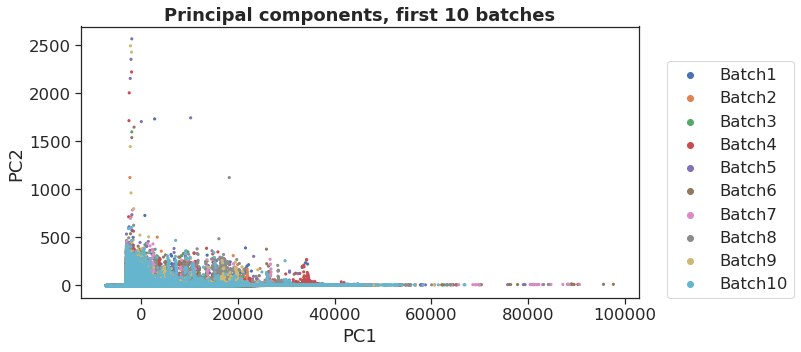

In [5]:
X = batch_df[['charge','time']]
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
pcdf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2'])
pcdf['Batch'] = batch_df['Batch'].tolist()
sns.set(font_scale = 1.5,style = 'ticks')
plt.figure(figsize = (10,5))
ax = sns.scatterplot(data = pcdf,x = 'PC1',y = 'PC2',hue = 'Batch',linewidth =0,s = 10)
plt.legend(loc = [1.05,0])
plt.title('Principal components, first 10 batches',weight = 'bold')

### Overall, total 10 batched seems to have similar characteristics.
- But it seems that red dots (Batch 4) around PC1 ~35,000 is quite isolated from other batches.



# How to remove batch effects ?
- There are several renowned methods for removing batch effects in molecular biology ( Mainly for sequencing )
- We're going to use pyComBat, one of the ComBat Series!
- https://www.biorxiv.org/content/10.1101/2020.03.17.995431v2
- https://github.com/epigenelabs/pyComBat

In [12]:
# !pip install combat
from combat.pycombat import pycombat

In [7]:
# Combat input pre-processing.
batch = batch_df['Batch'].tolist()
combat_input = batch_df.reset_index(drop = True)
combat_input = combat_input.drop(['Batch','sensor_id','auxiliary'],axis=1)
combat_input = combat_input.T

## Run pyComBat


In [8]:
df_corrected = pycombat(combat_input,batch)

Found 10 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [9]:
combat_corrected = df_corrected.T

# Check if the batch effect is removed?

Text(0.5, 1.0, 'After removing batch effect')

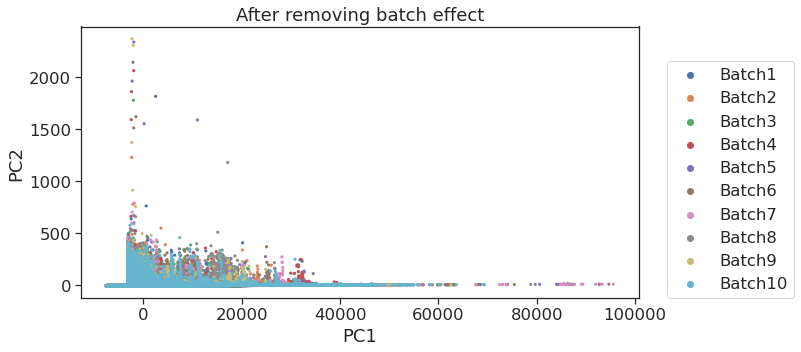

In [10]:
X_corrected = combat_corrected
pca = PCA(n_components=2)
printcipalComponents_corrected = pca.fit_transform(X_corrected)
pcdf_corrected = pd.DataFrame(data=printcipalComponents_corrected, columns = ['PC1', 'PC2'])
pcdf_corrected['Batch'] = batch_df['Batch'].tolist()
sns.set(font_scale = 1.5,style = 'ticks')
plt.figure(figsize = (10,5))
sns.scatterplot(data = pcdf_corrected,x = 'PC1',y = 'PC2',hue = 'Batch',linewidth =0,s = 10)
plt.legend(loc = [1.05,0])
plt.title('After removing batch effect')

- Looks like batch effect related to the Red Dot ( Batch 4 ) is somewhat diminished!
- Let's check the result in pair. 

## Result of batch effect removal

Text(0.5, 1.0, 'After removing batch effect')

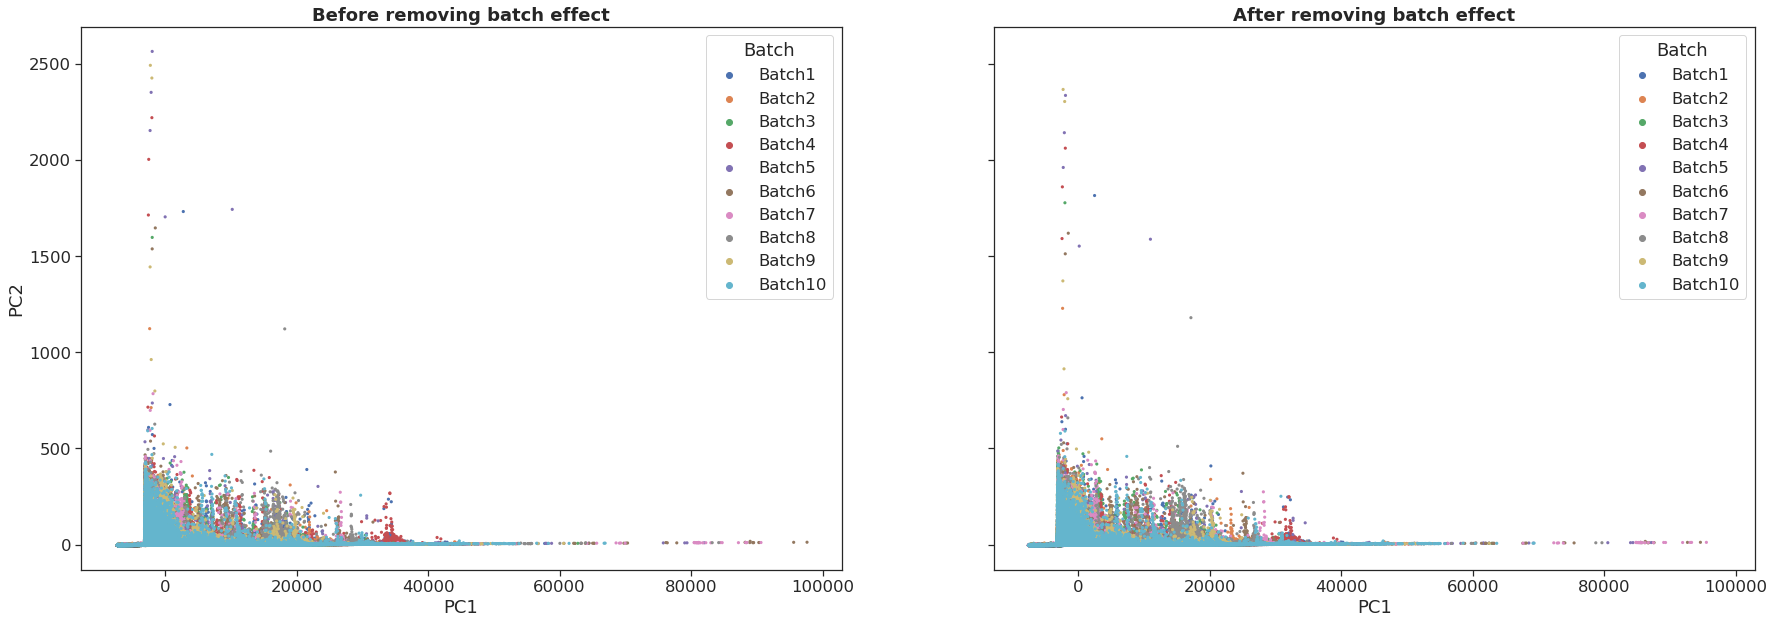

In [11]:
fig,axes = plt.subplots(1,2,figsize = (30,10),sharex = True,sharey = True)

sns.scatterplot(data = pcdf,x = 'PC1',y = 'PC2',hue = 'Batch',linewidth =0,s = 10,ax = axes[0])
axes[0].set_title('Before removing batch effect',weight = 'bold')
sns.scatterplot(data = pcdf_corrected,x = 'PC1',y = 'PC2',hue = 'Batch',linewidth =0,s = 10,ax = axes[1])
axes[1].set_title('After removing batch effect',weight = 'bold')


# There are over 600 batches in total, how can we compare all of them? ( On-going )
- Plotting all batches in a single figure would cost us an immense amount of time and resource
- And even if we plot it, the chances are high that we cannot distinguish other batches by dot size, color... etc by a single plot.
- So why not try PCA explainable values?
- Retrieve all pairs of 660 batches, and calculate PCA explained variance ratio and get the pair of batches with lowest ratio

In [ ]:
batch_dir = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'
batchdat_lst=[]
for i in tqdm(range(660)):
    i = i+1
    batch_dat = get_batchdata(i,batch_dir)
    batch_dat = batch_dat.sample(frac=0.0001)
    batch_dat['Batch'] = 'Batch'+str(i)
    batchdat_lst.append(batch_dat)
    batch_df = pd.concat(batchdat_lst)

X = batch_df[['charge','time']].to_numpy()
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
pca_x_ratio = pca.explained_variance_ratio_
